# Drug-Drug Similiarity System

Based on the best model among the 6 graph embedding algorithms, we are going to use the embeddings, link predictions and the drug clustering to create a combined system to find the similiarities among the drug. This system will also help us find a similiar drug for any given input drug. 

# Setup Notebook and GPU

In [ ]:
# Monunt google drive to import KEGG dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Setting Colab's GPU
# Edit > Notebook Settings > GPU 
!nvidia-smi -L
# Detailed GPU Information Reference: https://medium.com/analytics-vidhya/the-google-colab-system-specification-check-69d159597417
# !nvidia-smi -q

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-36e2419d-af0f-5332-69ec-7b00ed649a23)


In [ ]:
!lscpu |grep 'Model name'

Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz


# Import libraries

In [ ]:
%%capture 
!pip install ampligraph;
%tensorflow_version 1.x 
import numpy as np
import pandas as pd
import ampligraph
from ampligraph.datasets import load_from_csv
from tabulate import tabulate
ampligraph.__version__

# Import Dataset

In [ ]:
# Load the KEGG dataset
df = load_from_csv('.','drive/My Drive/datasets/KEGG/KEGG50K.txt',sep='\t')
headers = ["Head", "Relationship", "Tail"]
table = tabulate(df[:5], headers, tablefmt="fancy_grid") # tabulate data Reference: https://stackoverflow.com/questions/9712085/numpy-pretty-print-tabular-data
print(table) # output

╒══════════╤══════════════════╤═══════════╕
│ Head     │ Relationship     │ Tail      │
╞══════════╪══════════════════╪═══════════╡
│ hsa04024 │ PATHWAY_GENE     │ HSA:51196 │
├──────────┼──────────────────┼───────────┤
│ D02042   │ DRUG_TARGET_GENE │ HSA:5139  │
├──────────┼──────────────────┼───────────┤
│ N00399   │ NETWORK_GENE     │ HSA:2790  │
├──────────┼──────────────────┼───────────┤
│ hsa04912 │ PATHWAY_GENE     │ HSA:6654  │
├──────────┼──────────────────┼───────────┤
│ H00342   │ DISEASE_GENE     │ HSA:6556  │
╘══════════╧══════════════════╧═══════════╛


In [ ]:
print('Full set size: ', df.shape)

Full set size:  (63080, 3)


In [ ]:
positives_filter = df

# Graph Embedding Algorithm

The best performance was given by the ComplEx algorithms providing the best scores on link prediction tasks. The configurations are as follows:

* **Embedding size**: 300
* **Optimizer**: adam
* **Learning rate**: 0.001
* **Loss**: Multiclass NLL Loss
* **Regularization type**: 3
* **Regularization constant**: 0.01

In [ ]:
"""
Model configs ( Embedding size :  300 , Optimizer :  adam , with learning rate :  0.001 , Loss :  multiclass_nll ,regularization type:  3  regularization constant lambda:  0.01  )
Execution time: 136.5050220489502 seconds.
Number :  31
MRR: 0.46
Hits@10: 0.64
Hits@3: 0.49
Hits@1: 0.37
"""
from ampligraph.latent_features import ComplEx

model = ComplEx(batches_count=100, 
                seed=0, 
                epochs=200, 
                k=300, 
                eta=5,
                optimizer='adam', 
                optimizer_params={'lr':1e-3},
                loss='multiclass_nll',                     # Multiclass NLL Loss Reference: https://docs.ampligraph.org/en/latest/generated/ampligraph.latent_features.NLLMulticlass.html#ampligraph.latent_features.NLLMulticlass
                regularizer='LP', 
                regularizer_params={'p':3,'lambda':1e-2},  # The nuclear 3-norm proposed in the ComplEx-N3 from paper LUO18, proves to be effective for DistMult and ComplEx Reference: https://github.com/DeepGraphLearning/KnowledgeGraphEmbedding/issues/6 
                verbose=True)


#### Fitting model

In [ ]:
import tensorflow as tf
import time
tf.logging.set_verbosity(tf.logging.ERROR)
start_time = time.time()
model.fit(df, early_stopping = False)
print("Execution time: %s seconds." % (time.time() - start_time))

Average ComplEx Loss:   0.166244: 100%|██████████| 200/200 [02:25<00:00,  1.37epoch/s]

Execution time: 146.9967978000641 seconds.


#### Saving model


In [ ]:
from ampligraph.latent_features import save_model, restore_model
save_model(model, './ComplEx_Model.pkl')

#### Generating Embeddings for Entities

In [ ]:
entities = np.unique(np.concatenate([df[:, 0], df[:, 2]]))
relations = np.unique(df[:, 1])

In [ ]:
entity_embeddings = dict(zip(entities, model.get_embeddings(entities)))

In [ ]:
len(entity_embeddings['D00043'])

600

# Cosine Similarity among Graphical Embeddings

We will first find the the top k similiar drugs based on cosine similiarities wrt other drugs.

In [ ]:
def entityType(n):         # Utility functon to return entity type
  if n.startswith("h"):
    return "PATHWAY"
  elif n.startswith("D"):
    return "DRUG"
  elif n.startswith("N"):
    return "NETWORK"
  elif n.startswith("HS"):
    return "GENE"
  else:
    return "DISEASE"

In [ ]:
entityTypeList = list(map(entityType,entities))
print(pd.DataFrame({"Entity": entities[:6000],"Type":entityTypeList[:6000]}))

      Entity     Type
0     D00043     DRUG
1     D00045     DRUG
2     D00049     DRUG
3     D00058     DRUG
4     D00059     DRUG
...      ...      ...
5995  H01519  DISEASE
5996  H01521  DISEASE
5997  H01522  DISEASE
5998  H01523  DISEASE
5999  H01524  DISEASE

[6000 rows x 2 columns]


In [ ]:
drugList = []
geneList,diseaseList,pathwayList=[],[],[]
for i,entity in enumerate(entityTypeList):
  if entityTypeList[i]=='DRUG':
    drugList.append(entities[i])
  elif entityTypeList[i]=='GENE':
    geneList.append(entities[i])
  elif entityTypeList[i]=='DISEASE':
    diseaseList.append(entities[i])
  elif entityTypeList[i]=='PATHWAY':
    pathwayList.append(entities[i])

In [ ]:
print("Total number of unique drugs : ",len(drugList))

Total number of unique drugs :  4670


In [ ]:
#print("Name of Drug :",drugList[0]," Embedding :",entity_embeddings[drugList[0]])

In [ ]:
from scipy import spatial
def cosineSimilarity(emd1,emd2):
  return 1 - spatial.distance.cosine(emd1,emd2)

In [ ]:
cosineSimilarity(entity_embeddings[drugList[0]],entity_embeddings[drugList[0]])

1.0

In [ ]:
def findSimiliarDrugs(drug,drugList,k):     # Utility function to find top k similiar drugs wrt the input drug
  similarityMap = dict()
  drugEmbedding = entity_embeddings[drug]
  for ent in drugList:
    if ent != drug:
      similarityMap[ent] = cosineSimilarity(drugEmbedding,entity_embeddings[ent])
  return sorted(similarityMap.items(), key=lambda kv: -kv[1])[:k] # return a sorted dictionary 

In [ ]:
k = findSimiliarDrugs('D00043',drugList,10)

In [ ]:
drugs,cosines=[],[]
for u,v in k:
  drugs.append(u)
  cosines.append(v)
# Top 10 drugs similiar based on cosine similairity between graph embeddings
pd.DataFrame({'drug':drugs,'cosine':cosines})

,drug,cosine
0,D02558,0.957066
1,D04435,0.952487
2,D02418,0.944881
3,D03751,0.943170
4,D00196,0.939603
5,D05215,0.937451
6,D09835,0.937329
7,D08838,0.934938
8,D03826,0.934139
9,D05981,0.934112


* **D00043**: Name is Isoflurophate
Fluostigmine, name(TN) is Floropryl (TN). Also is part of two drug groups as per KEGG database DG01593 (Acetylcholinesterase inhibitor) Class: Neuropsychiatric agent and DG01594 (Butyrylcholinesterase inhibitor)	Class: Neuropsychiatric agent.
* **D02558**: Name is Rivastigmine tartrate
Rivastigmine hydrogen tartrate used for Alzheimer's disease (DS:H00056). Also is a part of drug group DG00984 (Rivastigmine).


# Clustering on Graphical Embeddings of Drugs

In [ ]:
%%capture
!pip install seaborn adjustText
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
%matplotlib inline

In [ ]:
drug_embeddings = dict(zip(drugList, model.get_embeddings(drugList)))

In [ ]:
embeddings_2d = PCA(n_components=2).fit_transform(np.array([i for i in drug_embeddings.values()]))
embeddings_2d[:2]

array([[ 0.12228587, -0.055627  ],
       [-0.9344892 ,  0.5016429 ]], dtype=float32)

In [ ]:
def plot_clusters(hue,df,saved=False,figname='default.png'):
  np.random.seed(0)
  plt.figure(figsize=(12, 12))
  plt.title("{} embeddings".format(hue).capitalize())
  ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue=hue)
  if saved==True:
    plt.savefig(figname,bbox_inches = 'tight')

In [ ]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

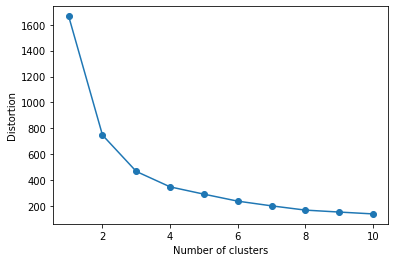

In [ ]:
# https://github.com/prakhargurawa/Machine-Learning-A-Z/blob/main/4_Clustering/k_means_clustering.py
# https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
WCSS = []
for i in range(1, 11):
    km = KMeans(n_clusters=i, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
    km.fit(embeddings_2d )
    WCSS.append(km.inertia_)

# plot
plt.plot(range(1, 11), WCSS, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()
# 3 is perfect for now

In [ ]:
clustering_algorithm = KMeans(n_clusters=3, n_init=50, max_iter=500, random_state=0,init = 'k-means++')
clusters = find_clusters(np.array(drugList), model, clustering_algorithm, mode='entity')

In [ ]:
plot_df = pd.DataFrame({"Drug": drugList, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "cluster": "cluster" + pd.Series(clusters).astype(str)})
plot_df

,Drug,embedding1,embedding2,cluster
0,D00043,0.122284,-0.055524,cluster2
1,D00045,-0.934490,0.501689,cluster1
2,D00049,0.308602,0.239287,cluster2
3,D00058,-0.336851,-0.337598,cluster1
4,D00059,-0.536265,0.042374,cluster1
...,...,...,...,...
4665,D11090,0.431909,-0.096071,cluster2
4666,D11092,0.324720,-0.141852,cluster2
4667,D11093,-0.229949,-0.255080,cluster1
4668,D11094,0.332193,-0.084985,cluster2


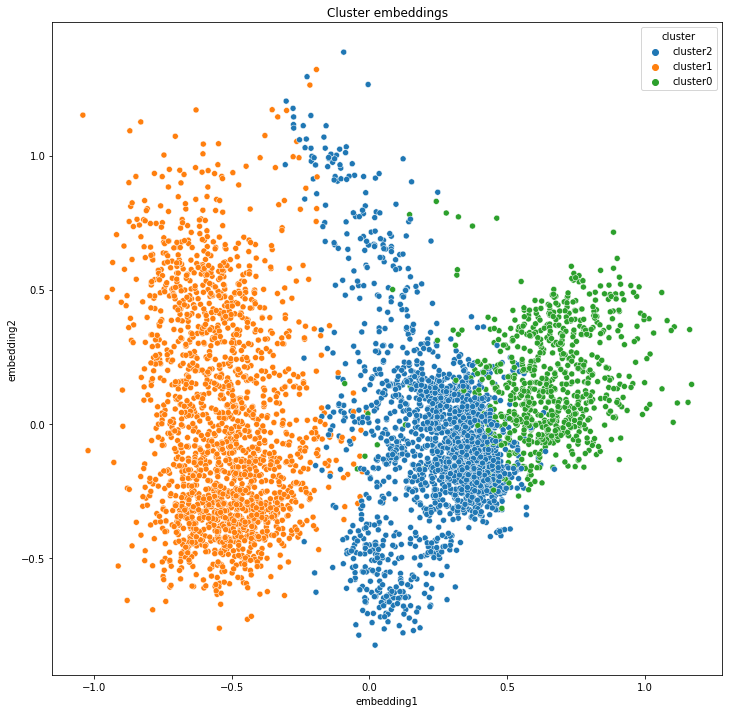

In [ ]:
plot_clusters("cluster",plot_df,saved=True,figname="drug-cluster.png")

In [ ]:
def entityType(n):         # Utility functon to return entity type
  if n.startswith("h"):
    return "PATHWAY"
  elif n.startswith("D"):
    return "DRUG"
  elif n.startswith("N"):
    return "NETWORK"
  elif n.startswith("HS"):
    return "GENE"
  else:
    return "DISEASE"
entityTypeList = list(map(entityType,drugList))

In [ ]:
entity_df = pd.DataFrame({"Drug": drugList, 
                        "embedding1": embeddings_2d[:, 0], 
                        "embedding2": embeddings_2d[:, 1],
                        "type":entityTypeList})
entity_df

,Drug,embedding1,embedding2,type
0,D00043,0.122286,-0.055627,DRUG
1,D00045,-0.934489,0.501643,DRUG
2,D00049,0.308602,0.239375,DRUG
3,D00058,-0.336850,-0.337673,DRUG
4,D00059,-0.536266,0.042381,DRUG
...,...,...,...,...
4665,D11090,0.431909,-0.096091,DRUG
4666,D11092,0.324720,-0.141777,DRUG
4667,D11093,-0.229949,-0.255154,DRUG
4668,D11094,0.332193,-0.084991,DRUG


In [ ]:
entity_df['type'] = np.where((entity_df.Drug == 'D00043'),'D00043',entity_df.type)     # Reference : https://kanoki.org/2019/07/17/pandas-how-to-replace-values-based-on-conditions/
for drug in drugs:
  entity_df['type'] = np.where((entity_df.Drug == drug),'Top similair drugs',entity_df.type)
entity_df

,Drug,embedding1,embedding2,type
0,D00043,0.122284,-0.055524,D00043
1,D00045,-0.934490,0.501689,DRUG
2,D00049,0.308602,0.239287,DRUG
3,D00058,-0.336851,-0.337598,DRUG
4,D00059,-0.536265,0.042374,DRUG
...,...,...,...,...
4665,D11090,0.431909,-0.096071,DRUG
4666,D11092,0.324720,-0.141852,DRUG
4667,D11093,-0.229949,-0.255080,DRUG
4668,D11094,0.332193,-0.084985,DRUG


In [ ]:
alphas = []
for drug in entity_df['Drug']:
  if drug == 'D00043' or drug in drugs:
    alphas.append(1.5)
  else:
    alphas.append(0.01)

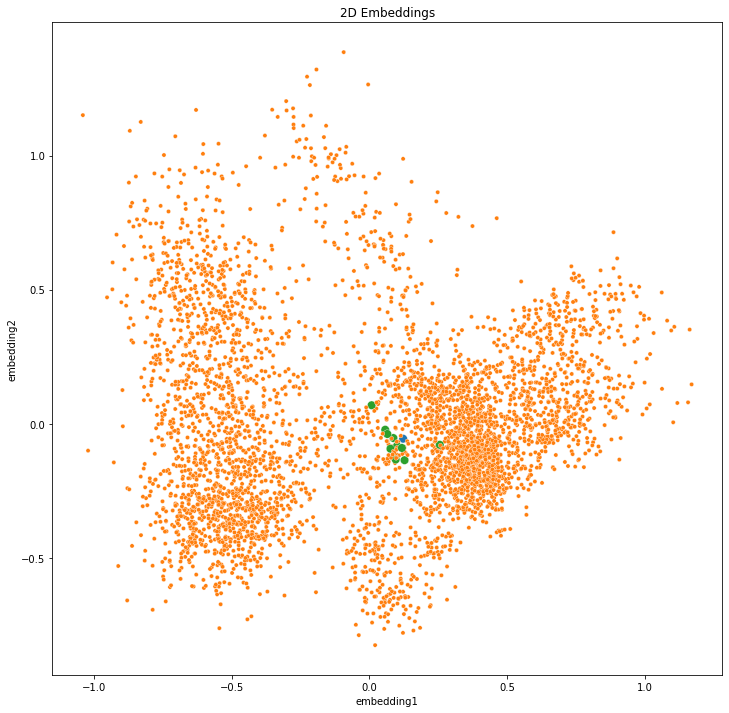

In [ ]:
def plot_clusters(hue,alpha,df,saved=False,figname='default.png'):
  np.random.seed(0)
  plt.figure(figsize=(12, 12))
  plt.title("2D Embeddings")
  ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue=hue,size=alpha,legend=False)
  if saved==True:
    plt.savefig(figname,bbox_inches = 'tight')

plot_clusters("type",alphas,entity_df,saved=True,figname="drug-plot.png")

# Link Prediction Errors

Drugs only have relationships with Genes, Pathways and Diseases. We will try to predict there links with other possible entities and try to find error between the link prediction between pair of drugs wrt to there scores with other entities. Similair drug should produce nearby link prediction scores wrt to other entities.

In [ ]:
geneList,diseaseList,pathwayList = [],[],[]
for i,entity in enumerate(entityTypeList):
  if entityTypeList[i]=='GENE':
    geneList.append(entities[i])
  elif entityTypeList[i]=='DISEASE':
    diseaseList.append(entities[i])
  elif entityTypeList[i]=='PATHWAY':
    pathwayList.append(entities[i])

In [ ]:
def generateData(drug,geneList,diseaseList,pathwayList):
  x = [[drug,'DRUG_TARGET_GENE',gene] for gene in geneList] + [[drug,'DRUG_EFFICACY_DISEASE',disease] for disease in diseaseList] + [[drug,'DRUG_TARGET_PATHWAY',pathway] for pathway in pathwayList] 
  return np.array(x)

In [ ]:
from ampligraph.evaluation import evaluate_performance
from scipy.special import expit

def findLinkPredictionDifference(drug1,drug2,geneList,diseaseList,pathwayList,positives_filter,model):
  X_unseen_drug1 = generateData(drug1,geneList,diseaseList,pathwayList)
  X_unseen_drug2 = generateData(drug2,geneList,diseaseList,pathwayList)

  # calculate scores
  scores_drug1 = model.predict(X_unseen_drug1)
  scores_drug2 = model.predict(X_unseen_drug2)
  # calculate probablities
  probs_drug1 = expit(scores_drug1)
  probs_drug2 = expit(scores_drug2)
  # calculate errors
  mses = ((np.array(probs_drug1)-np.array(probs_drug2))**2).mean()
  return mses


In [ ]:
error = findLinkPredictionDifference('D00043','D02558',geneList,diseaseList,pathwayList,positives_filter,model)
error

0.0003859504

In [ ]:
drugs,cosines,errors,ratio=[],[],[],[]
for u,v in k:
  drugs.append(u)
  cosines.append(v)
  error = findLinkPredictionDifference('D00043',u,geneList,diseaseList,pathwayList,positives_filter,model)
  errors.append(error)
  ratio.append(float(v/error))

In [ ]:
pd.DataFrame({'Drug':drugs,'Cosine':cosines,'Error':errors,'Ratio':ratio})

,Drug,Cosine,Error,Ratio
0,D02558,0.957066,0.000386,2479.764194
1,D04435,0.952487,0.000425,2239.125959
2,D02418,0.944881,0.000328,2884.443301
3,D03751,0.943170,0.000324,2915.059617
4,D00196,0.939603,0.000306,3075.463914
5,D05215,0.937451,0.000586,1599.055944
6,D09835,0.937329,0.000634,1479.373565
7,D08838,0.934938,0.000478,1956.548108
8,D03826,0.934139,0.000388,2404.652320
9,D05981,0.934112,0.000366,2555.506934


* **D00196**: Name Physostigmine (USP), part of drug group DG01132,	Physostigmine. Formula: C15H21N3O2.


#### Calculating top 10 drugs based on link prediction error

In [ ]:
drugs,cosines,errors,ratio=[],[],[],[]
drugEmbedding = entity_embeddings['D00043']
i = 0
for drug in drugList:
  i = i+1
  print(i)
  drugs.append(drug)
  if drug != 'D00043':
    v = cosineSimilarity(drugEmbedding,entity_embeddings[drug])
    cosines.append(v)
    error = findLinkPredictionDifference('D00043',drug,geneList,diseaseList,pathwayList,positives_filter,model)
    errors.append(error)
    ratio.append(float(v/error))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [ ]:
top10linkpredictionscore = pd.DataFrame({'Drug':drugList[1:],'Cosine':cosines,'Error':errors,'Ratio':ratio})

In [ ]:
top10linkpredictionscore

,Drug,Cosine,Error,Ratio
0,D00045,-0.006577,0.009865,-0.666735
1,D00049,0.096171,0.007508,12.808609
2,D00058,-0.047972,0.007153,-6.706309
3,D00059,0.187929,0.006389,29.413110
4,D00063,0.045981,0.005248,8.760783
...,...,...,...,...
4664,D11090,0.023420,0.009862,2.374785
4665,D11092,-0.026414,0.006129,-4.309749
4666,D11093,0.000141,0.007973,0.017623
4667,D11094,0.044530,0.008109,5.491367


In [ ]:
cosine_df = top10linkpredictionscore.sort_values(by=['Cosine'], ascending=False)
cosine_df[:10]

,Drug,Cosine,Error,Ratio
1412,D02558,0.957066,0.000386,2479.764194
2114,D04435,0.952487,0.000425,2239.125959
1388,D02418,0.944881,0.000328,2884.443301
1888,D03751,0.943170,0.000324,2915.059617
79,D00196,0.939603,0.000306,3075.463914
2354,D05215,0.937451,0.000586,1599.055944
3903,D09835,0.937329,0.000634,1479.373565
3571,D08838,0.934938,0.000478,1956.548108
1935,D03826,0.934139,0.000388,2404.652320
2568,D05981,0.934112,0.000366,2555.506934


In [ ]:
error_df = top10linkpredictionscore.sort_values(by=['Error'], ascending=True)
error_df[:10]

,Drug,Cosine,Error,Ratio
813,D01228,0.933001,0.000289,3223.509127
79,D00196,0.939603,0.000306,3075.463914
1888,D03751,0.943170,0.000324,2915.059617
1388,D02418,0.944881,0.000328,2884.443301
2673,D06288,0.918739,0.000339,2706.522993
284,D00469,0.928133,0.000347,2677.510252
2568,D05981,0.934112,0.000366,2555.506934
1412,D02558,0.957066,0.000386,2479.764194
1218,D02068,0.915335,0.000388,2357.032571
1935,D03826,0.934139,0.000388,2404.652320


In [ ]:
ratio_df = top10linkpredictionscore.sort_values(by=['Ratio'], ascending=False)
ratio_df[:10]

,Drug,Cosine,Error,Ratio
813,D01228,0.933001,0.000289,3223.509127
79,D00196,0.939603,0.000306,3075.463914
1888,D03751,0.943170,0.000324,2915.059617
1388,D02418,0.944881,0.000328,2884.443301
2673,D06288,0.918739,0.000339,2706.522993
284,D00469,0.928133,0.000347,2677.510252
2568,D05981,0.934112,0.000366,2555.506934
1412,D02558,0.957066,0.000386,2479.764194
1935,D03826,0.934139,0.000388,2404.652320
1218,D02068,0.915335,0.000388,2357.032571
